## Access Wave Buoy Realtime NonQC Webresponse (Parquet)
This Jupyter notebook demonstrates how to access and plot wave_buoy_realtime_nonqc_webresponse data, available as a [Parquet](https://parquet.apache.org) dataset stored on S3.

🔗 More information about the dataset is available [in the AODN metadata catalogue](https://catalogue-imos.aodn.org.au/geonetwork/srv/eng/catalog.search#/metadata/b299cdcd-3dee-48aa-abdd-e0fcdbb9cadc).

📌 The source of truth for this notebook is maintained on [GitHub](https://github.com/aodn/aodn_cloud_optimised/tree/main/notebooks/wave_buoy_realtime_nonqc_webresponse.ipynb).


In [1]:
dataset_name = "wave_buoy_realtime_nonqc_webresponse"

## Install/Update packages and Load common functions

In [2]:
import os, requests, importlib.util

open('setup.py', 'w').write(requests.get('https://raw.githubusercontent.com/aodn/aodn_cloud_optimised/main/notebooks/setup.py').text)

spec = importlib.util.spec_from_file_location("setup", "setup.py")
setup = importlib.util.module_from_spec(spec)
spec.loader.exec_module(setup)

setup.install_requirements()
setup.load_dataquery()

Using CPython 3.12.11 interpreter at: /home/lbesnard/miniforge3/envs/AodnCloudOptimised/bin/python3
Creating virtual environment at: .venv
Activate with: source .venv/bin/activate
Using Python 3.12.11 environment at: /home/lbesnard/miniforge3/envs/AodnCloudOptimised
Resolved 240 packages in 577ms
Audited 240 packages in 4ms
/home/lbesnard/github_repo/aodn_cloud_optimised/notebooks/DataQuery.py:3237: UserWarning: registration of accessor <class 'DataQuery.AODNAccessor'> under name 'aodn' for type <class 'pandas.core.frame.DataFrame'> is overriding a preexisting attribute with the same name.
  @pd.api.extensions.register_dataframe_accessor("aodn")


✅ Local version 0.2.9 is up to date (remote: 0.2.9)


In [3]:
from DataQuery import GetAodn

/home/lbesnard/github_repo/aodn_cloud_optimised/notebooks/DataQuery.py:3237: UserWarning: registration of accessor <class 'DataQuery.AODNAccessor'> under name 'aodn' for type <class 'pandas.core.frame.DataFrame'> is overriding a preexisting attribute with the same name.
  @pd.api.extensions.register_dataframe_accessor("aodn")


# Understanding the Dataset

## Understanding Parquet Partitioning

Parquet files can be **partitioned** by one or more columns, which means the data is physically organised into folders based on the values in those columns. This is similar to how databases use indexes to optimise query performance.

Partitioning enables **faster filtering**: when you query data using a partitioned column, only the relevant subset of files needs to be read—improving performance significantly.

For example, if a dataset is partitioned by `"site_code"`, `"timestamp"`, and `"polygon"`, filtering on `"site_code"` allows the system to skip unrelated files entirely.

In this notebook, the `GetAodn` class includes built-in methods to efficiently filter data by **time** and **latitude/longitude** using the **timestamp** and **polygon** partitions. Other partitions can be used for filtering via the `scalar_filter`.

Any filtering on columns that are **not** partitioned can be significantly slower, as all files may need to be scanned. However, the `GetAodn` class provides a `scalar_filter` method that lets you apply these filters at load time—before the data is fully read—helping reduce the size of the resulting DataFrame.

Once the dataset is loaded, further filtering using Pandas is efficient and flexible.

See further below in the notebook for examples of how to filter the data effectively.

To view the actual partition columns for this dataset, run:


In [4]:
aodn = GetAodn()
dname = f'{dataset_name}.parquet'
%time aodn_dataset = aodn.get_dataset(dname)

CPU times: user 32.6 ms, sys: 9.57 ms, total: 42.2 ms
Wall time: 3.29 s


In [5]:
aodn_dataset.dataset.partitioning.schema

timestamp: int32
polygon: string

## List unique partition values

In [6]:
%%time
unique_partition_value = aodn_dataset.get_unique_partition_values('timestamp')
print(list(unique_partition_value))  # showing a subset only

['1735689600', '1704067200', '1640995200', '1672531200']
CPU times: user 2.38 ms, sys: 1.34 ms, total: 3.72 ms
Wall time: 2.82 ms


## Visualise Spatial Extent of the dataset
This section plots the polygons representing the areas where data is available. It helps to identify and create a bounding box around the regions containing data.

/home/lbesnard/miniforge3/envs/AodnCloudOptimised/lib/python3.12/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


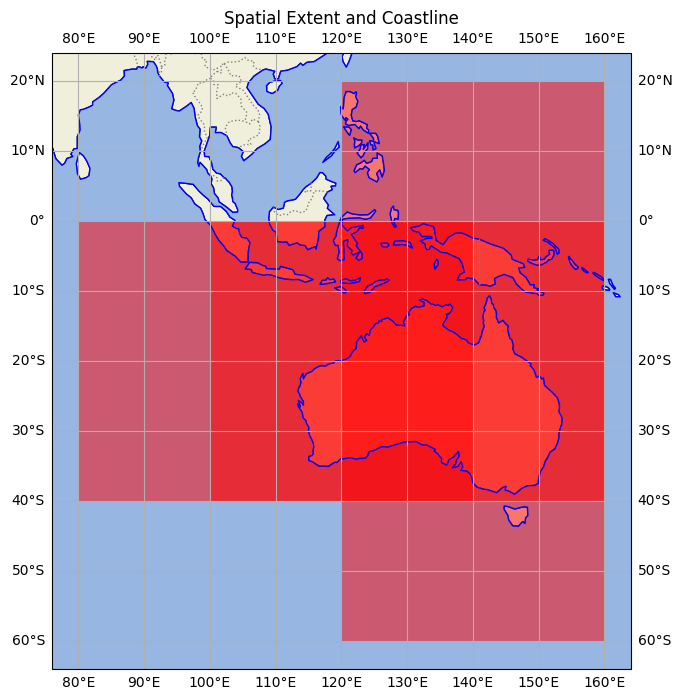

In [7]:
aodn_dataset.plot_spatial_extent()

## Get Temporal Extent of the dataset

Similary to the spatial extent, we're retrieving the minimum and maximum timestamp partition values of the dataset. This is not necessarely accurately representative of the TIME values, as the timestamp partition can be yearly/monthly... but is here to give an idea

In [8]:
%%time
aodn_dataset.get_temporal_extent()

CPU times: user 281 ms, sys: 163 ms, total: 444 ms
Wall time: 6.61 s


(Timestamp('2022-09-01 00:02:20'), Timestamp('2025-11-12 08:05:00'))

## Read Metadata

For all Parquet datasets, we create a sidecar file named **_common_metadata** in the root of the dataset. This file contains both the dataset-level and variable-level attributes.  
The metadata can be retrieved below as a dictionary, and it will also be included in the pandas DataFrame when using the `get_data` method from the `GetAodn` class.

In [9]:
metadata = aodn_dataset.get_metadata()
metadata

2025-11-12 19:48:01,473 - aodn.GetAodn - INFO - Retrieving metadata for imos-data-lab-optimised/wave_buoy_realtime_nonqc_webresponse.parquet


{'timeSeries': {'type': 'int32'},
 'TIME': {'type': 'timestamp[ns]'},
 'LATITUDE': {'type': 'double'},
 'LONGITUDE': {'type': 'double'},
 'WHTH': {'type': 'double'},
 'WPMH': {'type': 'double'},
 'WMXH': {'type': 'double'},
 'WPPE': {'type': 'double'},
 'WPDI': {'type': 'double'},
 'WPDS': {'type': 'double'},
 'WAVE_quality_control': {'type': 'float'},
 'filename': {'type': 'string'},
 'wmo_id': {'type': 'string'},
 'water_depth': {'type': 'int64'},
 'WSSH': {'type': 'double'},
 'WPFM': {'type': 'double'},
 'WMDS': {'type': 'double'},
 'SSWMD': {'type': 'double'},
 'site_name': {'type': 'string'},
 'timestamp': {'type': 'int64',
  'units': '1',
  'long_name': 'Partition timestamp'},
 'polygon': {'type': 'string',
  'units': '1',
  'long_name': 'Spatial partition polygon'},
 'global_attributes': {'metadata_uuid': 'b299cdcd-3dee-48aa-abdd-e0fcdbb9cadc',
  'dataset_name': 'wave_buoy_realtime_nonqc_webresponse',
  'title': 'WAVE BUOY web response'}}

# Data Query and Plot

## Create a TIME and BoundingBox filter

This cell loads a subset of the dataset based on a time range and a spatial bounding box. The result is returned as a pandas DataFrame, and basic information about its structure is displayed.

In [10]:
%%time
df = aodn_dataset.get_data(date_start='2022-12-01', date_end='2023-01-01',lat_min=-40, lat_max=-20, lon_min=140, lon_max=160)
df.info()

2025-11-12 19:48:07,297 - aodn.GetAodn - INFO - Retrieving metadata for imos-data-lab-optimised/wave_buoy_realtime_nonqc_webresponse.parquet


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28243 entries, 0 to 28242
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   timeSeries            28243 non-null  int32         
 1   TIME                  28243 non-null  datetime64[ns]
 2   LATITUDE              28243 non-null  float64       
 3   LONGITUDE             28243 non-null  float64       
 4   WHTH                  14889 non-null  float64       
 5   WPMH                  14889 non-null  float64       
 6   WMXH                  14889 non-null  float64       
 7   WPPE                  28239 non-null  float64       
 8   WPDI                  27269 non-null  float64       
 9   WPDS                  27269 non-null  float64       
 10  WAVE_quality_control  28243 non-null  float32       
 11  filename              28243 non-null  object        
 12  wmo_id                14893 non-null  object        
 13  water_depth     

In [11]:
## Download Subsetted Data as CSV

# This cell downloads the filtered dataset as a ZIP-compressed CSV file.  
# The CSV includes metadata at the top as commented lines, and a `FileLink` object is returned to allow downloading directly from the notebook.


df.aodn.download_as_csv()

/home/lbesnard/github_repo/aodn_cloud_optimised/notebooks/aodn_metadata-uuid_b299cdcd-3dee-48aa-abdd-e0fcdbb9cadc_wave_buoy_realtime_nonqc_webresponse_data-hash_667aa3e0.csv.zip

## Create a TIME and scalar/number filter

This cell filters the dataset by time range and a scalar value (from a Parquet partition) using the `scalar_filter` argument.  
This leverages Parquet partitioning to apply efficient, server-side filtering, which significantly speeds up data loading.

In [12]:
%%time
df = aodn_dataset.get_data( date_start='2025-10-12', date_end='2025-11-02', scalar_filter= {'site_name': 'VICTOR-HARBOUROFFSHORE'})
df.info()

2025-11-12 19:48:12,910 - aodn.GetAodn - INFO - Retrieving metadata for imos-data-lab-optimised/wave_buoy_realtime_nonqc_webresponse.parquet


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20160 entries, 0 to 20159
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   timeSeries            20160 non-null  int32         
 1   TIME                  20160 non-null  datetime64[ns]
 2   LATITUDE              20160 non-null  float64       
 3   LONGITUDE             20160 non-null  float64       
 4   WHTH                  0 non-null      float64       
 5   WPMH                  0 non-null      float64       
 6   WMXH                  0 non-null      float64       
 7   WPPE                  504 non-null    float64       
 8   WPDI                  504 non-null    float64       
 9   WPDS                  504 non-null    float64       
 10  WAVE_quality_control  504 non-null    float32       
 11  filename              20160 non-null  object        
 12  wmo_id                0 non-null      object        
 13  water_depth     

<Axes: xlabel='TIME'>

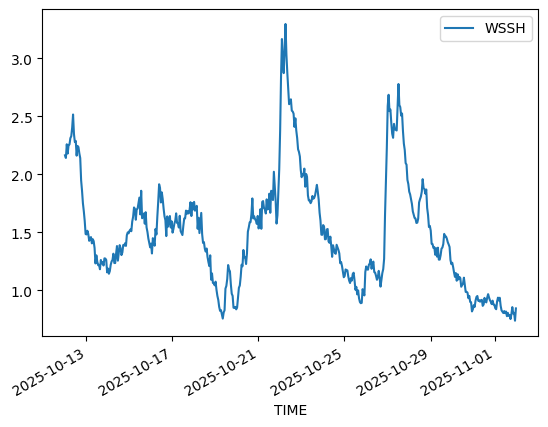

In [13]:
df_valid = df[df['WSSH'].notna()].sort_values('TIME')
df_valid[df_valid['WAVE_quality_control'] == 1].plot(
    x='TIME',
    y='WSSH',
    kind='line',
    #ylabel=metadata['WSSH']['standard_name']
)